In [1]:
!git clone https://github.com/jan1na/Neural-Cellular-Automata.git

%cd Neural-Cellular-Automata

Cloning into 'Neural-Cellular-Automata'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 119 (delta 71), reused 51 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 512.51 KiB | 13.49 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/Neural-Cellular-Automata


In [2]:
!pip install medmnist torch torchvision tqdm

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PathMNIST, INFO
from train_utils import train, evaluate, plot_training_history
from models import NCA2
import matplotlib.pyplot as plt
import random
import os

# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 206M/206M [01:57<00:00, 1.74MB/s]


# Dataset Overview

In [4]:
print(f"train_dataset length: {len(train_dataset)}")
print(f"val_dataset length: {len(val_dataset)}")
print(f"Numb classes: {INFO['pathmnist']['label']}")
print(f"Data shape: {train_dataset[0][0].shape}")

train_dataset length: 89996
val_dataset length: 10004
Numb classes: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Data shape: torch.Size([3, 28, 28])


In [7]:
model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
n_classes = len(INFO['pathmnist']['label'])

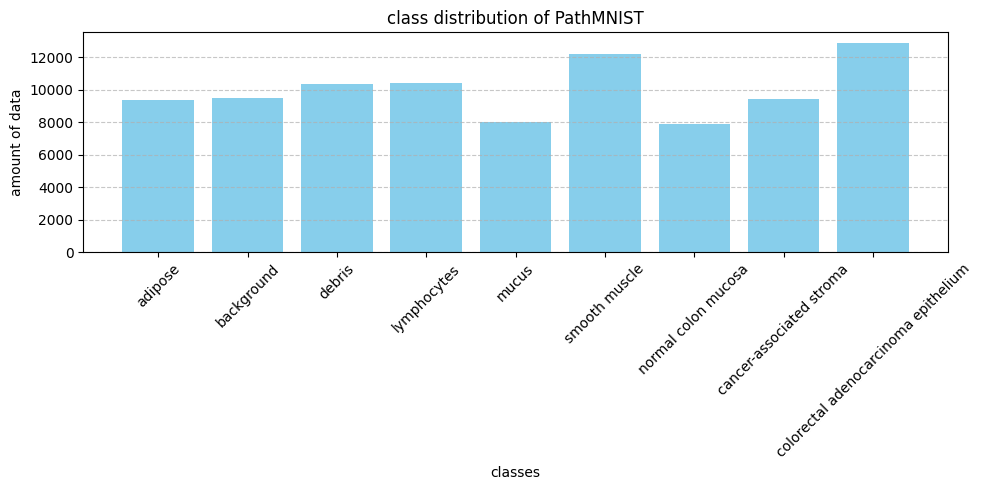

In [8]:
# plotting class distribution

data_dist_path = '/content/drive/MyDrive/NCA/plots/data_distribution.png'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

class_counts = [0] * n_classes

for data, target in train_loader:
    for label in target:
        class_counts[label.item()] += 1

class_labels = list(INFO['pathmnist']['label'].values())
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('class distribution of PathMNIST')
plt.xlabel('classes')
plt.ylabel('amount of data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(data_dist_path, dpi=300)
plt.show()

/tmp/ipython-input-9-3273146053.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(label) == i:


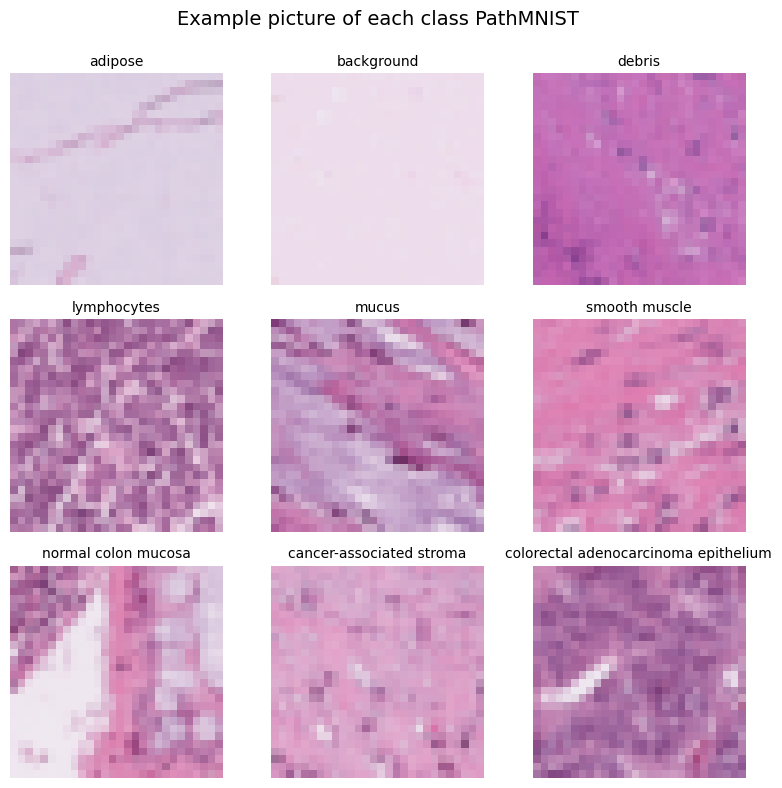

In [9]:
# plotting a picture of each class

test_data_path = '/content/drive/MyDrive/NCA/plots/test_data.png'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Example picture of each class PathMNIST", fontsize=14)

for i, ax in enumerate(axes.flat):

    # searching for random picture and plotting it
    for image, label in train_dataset:
        if int(label) == i:
            img = image.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(class_labels[i], fontsize=10)
            ax.axis('off')
            break


plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(test_data_path, dpi=300)
plt.show()

# Train and plot data

Epoch 01: Train Acc: 0.7018, Val Acc: 0.8574
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 02: Train Acc: 0.8461, Val Acc: 0.8533


Epoch 03: Train Acc: 0.8700, Val Acc: 0.9010
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 04: Train Acc: 0.8869, Val Acc: 0.8596


Epoch 05: Train Acc: 0.9007, Val Acc: 0.8969


Epoch 06: Train Acc: 0.9113, Val Acc: 0.9284
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 07: Train Acc: 0.9193, Val Acc: 0.9397
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 08: Train Acc: 0.9243, Val Acc: 0.9422
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 09: Train Acc: 0.9304, Val Acc: 0.9428
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 10: Train Acc: 0.9350, Val Acc: 0.9319


Epoch 11: Train Acc: 0.9380, Val Acc: 0.9352


Epoch 12: Train Acc: 0.9411, Val Acc: 0.9292


Epoch 13: Train Acc: 0.9439, Val Acc: 0.9407


Epoch 14: Train Acc: 0.9464, Val Acc: 0.9503
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 15: Train Acc: 0.9485, Val Acc: 0.9306


Epoch 16: Train Acc: 0.9498, Val Acc: 0.9377


Epoch 17: Train Acc: 0.9523, Val Acc: 0.9434


Epoch 18: Train Acc: 0.9535, Val Acc: 0.9540
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 19: Train Acc: 0.9547, Val Acc: 0.9568
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 20: Train Acc: 0.9560, Val Acc: 0.9607
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth
Converged (validation accuracy > 96%)
Training completed.


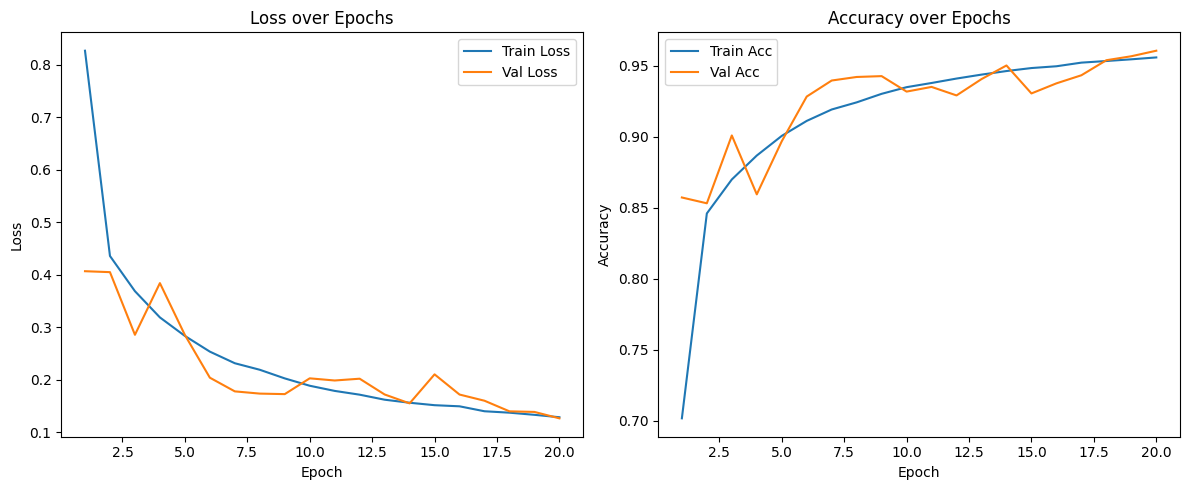

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCA2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 30

model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

plot_save_path = '/content/drive/MyDrive/NCA/plots/nca_training_history.png'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, is_NCA=True)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, is_NCA=True)

    # Save for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved to {model_path}")

    if val_acc > 0.99:
        print("Converged (validation accuracy > 96%)")
        break

print("Training completed.")
plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, plot_save_path)